# <div style='color:white;background: #005792;text-align: center;padding: 15px 0'>Recommandations - Modélisation d'un modèle machine learning basé sur du Filtrage Collaboratif </div>

## Participants
* Samantha
* Rachelle
* Andrew

### Installation des librairies

In [6]:
#!pip install scikit-learn
#!pip install tabulate

### Importation des librairies

In [4]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

### Chargement des fichiers 

In [5]:
source_dir= '/home/dstrec/dstrec/010_data/002_merged'
file_final = f"{source_dir}/dstrec.csv"

In [6]:
df = pd.read_csv(file_final)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164108 entries, 0 to 164107
Data columns (total 39 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   imdbId         164108 non-null  object 
 1   title          164108 non-null  object 
 2   averageRating  164108 non-null  float64
 3   numVotes       164108 non-null  float64
 4   director       164108 non-null  object 
 5   actor_actress  164108 non-null  object 
 6   producer       164108 non-null  object 
 7   Action         164108 non-null  int64  
 8   Adult          164108 non-null  int64  
 9   Adventure      164108 non-null  int64  
 10  Animation      164108 non-null  int64  
 11  Biography      164108 non-null  int64  
 12  Comedy         164108 non-null  int64  
 13  Crime          164108 non-null  int64  
 14  Documentary    164108 non-null  int64  
 15  Drama          164108 non-null  int64  
 16  Family         164108 non-null  int64  
 17  Fantasy        164108 non-nul

In [8]:
df.head()

,imdbId,title,averageRating,numVotes,director,actor_actress,producer,Action,Adult,Adventure,...,Romance,Sci,Show,Sport,TV,Talk,Thriller,War,Western,forAdult
0,tt0000009,Miss Jerry,5.4,212.0,Alexander Black,William Courtenay/Blanche Bayliss,Alexander Black,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,tt0000574,The Story of the Kelly Gang,6.0,900.0,Charles Tait,Godfrey Cass/Bella Cola,W.A. Gibson,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,tt0001370,Rainha Depois de Morta Inês de Castro,5.2,26.0,Carlos Santos,Eduardo Brazão/Amelia Vieira,Júlio Costa,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0001790,"Les Misérables, Part 1: Jean Valjean",6.0,52.0,Albert Capellani,Jean Angelo/Maria Fromet,Pierre Decourcelle,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0001911,Nell Gwynne,3.6,26.0,Raymond Longford,Walter Bastin/Agnes Keogh,George Musgrove,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Implémentation du modèle

In [9]:
import re

In [10]:
#Pour éviter les biais et mauvaises interprétations des éléments, on retraite les colonnes

In [11]:
#Retraitement producer
r1 = re.compile(r"\s")
r2 = re.compile(r"/")
for i in range(len(df)):
    df.loc[i,'producer']=r1.sub('', str(df.loc[i,'producer']))
    df.loc[i,'producer']=r2.sub(' ', str(df.loc[i,'producer']))

print(df['producer'])

0             AlexanderBlack
1                 W.A.Gibson
2                 JúlioCosta
3          PierreDecourcelle
4             GeorgeMusgrove
                 ...        
164103          ArturoPaglia
164104           KoldoZuazua
164105           M.AbduhAziz
164106    MeghrajRajebhosale
164107          UjjwalaGawde
Name: producer, Length: 164108, dtype: object


In [12]:
#Retraitement director
r1 = re.compile(r"\s")
r2 = re.compile(r"/")
for i in range(len(df)):
    df.loc[i,'director']=r1.sub('', str(df.loc[i,'director']))
    df.loc[i,'director']=r2.sub(' ', str(df.loc[i,'director']))

print(df['director'])

0          AlexanderBlack
1             CharlesTait
2            CarlosSantos
3         AlbertCapellani
4         RaymondLongford
               ...       
164103      GiacomoCimini
164104        PabloAgüero
164105    AzharKinoiLubis
164106       KanchanNayak
164107        KiranGawade
Name: director, Length: 164108, dtype: object


In [13]:
#Retraitement actor_actress
r1 = re.compile(r"\s")
r2 = re.compile(r"/")
for i in range(len(df)):
    df.loc[i,'actor_actress']=r1.sub('', str(df.loc[i,'actor_actress']))
    df.loc[i,'actor_actress']=r2.sub(' ', str(df.loc[i,'actor_actress']))

print(df['actor_actress'])

0         WilliamCourtenay BlancheBayliss
1                   GodfreyCass BellaCola
2              EduardoBrazão AmeliaVieira
3                  JeanAngelo MariaFromet
4                 WalterBastin AgnesKeogh
                       ...               
164103    SergioCastellitto AnnaFoglietta
164104           AlexBrendemühl ElenaUriz
164105                SahilShah RiaIrawan
164106       PradipKothmire AshwiniEkbote
164107           SunilBarve AmrutaSubhash
Name: actor_actress, Length: 164108, dtype: object


In [14]:
df['genres']=''
for i in df[df.columns[7:38]].columns.values:
    nom_col=i
    df[i] = df[i].replace([0, 1], ['', nom_col])
    df['genres']=df['genres']+"/"+df[i]

r = re.compile(r"/+")
for i in range(len(df)):
    df.loc[i,'genres']=r.sub(' ', str(df.loc[i,'genres']))

print(df['genres'])

0                             Romance 
1          Action Adventure Biography 
2                       Drama History 
3                               Drama 
4             Biography Drama History 
                      ...             
164103                       Thriller 
164104                  Drama History 
164105                          Drama 
164106                         Comedy 
164107                          Drama 
Name: genres, Length: 164108, dtype: object


In [15]:
df['desc']=df['director']+" "+df['actor_actress']+" "+df['producer']+" "+df['genres']

In [16]:
#r = re.compile(r"/+")
#for i in range(len(df)):
#    df.loc[i,'desc']=r.sub(' ', str(df.loc[i,'desc']))

In [17]:
print(df['desc'])

0         AlexanderBlack WilliamCourtenay BlancheBayliss...
1         CharlesTait GodfreyCass BellaCola W.A.Gibson  ...
2         CarlosSantos EduardoBrazão AmeliaVieira JúlioC...
3         AlbertCapellani JeanAngelo MariaFromet PierreD...
4         RaymondLongford WalterBastin AgnesKeogh George...
                                ...                        
164103    GiacomoCimini SergioCastellitto AnnaFoglietta ...
164104    PabloAgüero AlexBrendemühl ElenaUriz KoldoZuaz...
164105    AzharKinoiLubis SahilShah RiaIrawan M.AbduhAzi...
164106    KanchanNayak PradipKothmire AshwiniEkbote Megh...
164107    KiranGawade SunilBarve AmrutaSubhash UjjwalaGa...
Name: desc, Length: 164108, dtype: object


In [18]:
df.head()

,imdbId,title,averageRating,numVotes,director,actor_actress,producer,Action,Adult,Adventure,...,Show,Sport,TV,Talk,Thriller,War,Western,forAdult,genres,desc
0,tt0000009,Miss Jerry,5.4,212.0,AlexanderBlack,WilliamCourtenay BlancheBayliss,AlexanderBlack,,,,...,,,,,,,,0,Romance,AlexanderBlack WilliamCourtenay BlancheBayliss...
1,tt0000574,The Story of the Kelly Gang,6.0,900.0,CharlesTait,GodfreyCass BellaCola,W.A.Gibson,Action,,Adventure,...,,,,,,,,0,Action Adventure Biography,CharlesTait GodfreyCass BellaCola W.A.Gibson ...
2,tt0001370,Rainha Depois de Morta Inês de Castro,5.2,26.0,CarlosSantos,EduardoBrazão AmeliaVieira,JúlioCosta,,,,...,,,,,,,,0,Drama History,CarlosSantos EduardoBrazão AmeliaVieira JúlioC...
3,tt0001790,"Les Misérables, Part 1: Jean Valjean",6.0,52.0,AlbertCapellani,JeanAngelo MariaFromet,PierreDecourcelle,,,,...,,,,,,,,0,Drama,AlbertCapellani JeanAngelo MariaFromet PierreD...
4,tt0001911,Nell Gwynne,3.6,26.0,RaymondLongford,WalterBastin AgnesKeogh,GeorgeMusgrove,,,,...,,,,,,,,0,Biography Drama History,RaymondLongford WalterBastin AgnesKeogh George...


In [19]:
# Créer un TfidfVectorizer et supprimer les mots vides
tfidf = TfidfVectorizer(stop_words='english')

# Adapter et transformer les données en une matrice tfidf
matrice_tfidf = tfidf.fit_transform(df['desc'])

In [20]:
# Calculer un score pour chaque titre recherché

# Fonction pour calculer la similarité et obtenir les recommandations
def get_recommendations1(title, matrice_tfidf, df):
    if title not in df['title'].values:
        return "Ce film n'est pas dans la base de données."

    # Trouver l'index du film
    idx = df[df['title'] == title].index[0]
        
    # Calculer la similarité entre le film choisi et tous les autres
    cosine_sim = cosine_similarity(matrice_tfidf[idx:idx+1], matrice_tfidf).flatten()
    
    # Obtenir les indices des films les plus similaires
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:16]  # Top 10, excluant le film lui-même
    
    # Récupérer les titres des films recommandés
    movie_indices = [i[0] for i in sim_scores]
    recommanded_title=df['title'].iloc[movie_indices]
    score=[i[1] for i in sim_scores]

    return list(zip(movie_indices,recommanded_title,score))

### Recommandations du modèle

In [21]:
# Test de la fonction
get_recommendations1("Star Trek", matrice_tfidf, df)

[(97378, 'Star Trek Into Darkness', 1.0),
 (123732, 'Star Wars: Episode VII - The Force Awakens', 0.6892922381956457),
 (125577, 'Star Trek Beyond', 0.6354248162655886),
 (106415, 'Super 8', 0.6268663729842547),
 (124099, 'Star Wars: Episode IX - The Rise of Skywalker', 0.6109285232640244),
 (124293, 'The Cloverfield Paradox', 0.4243934382210097),
 (143146, 'Mission: Impossible - Fallout', 0.4051702017572601),
 (141037, 'Overlord', 0.399626992810283),
 (122189, 'Mission: Impossible - Rogue Nation', 0.3978491397207762),
 (83363, 'Cloverfield', 0.3956429509718999),
 (90227, 'Mission: Impossible - Ghost Protocol', 0.3870640399302054),
 (145550, 'Lou', 0.3831979263159812),
 (86228, 'Morning Glory', 0.3821574485659702),
 (50500, 'Joy Ride', 0.36913412868012785),
 (37325, 'The Pallbearer', 0.35791409981054173)]

In [22]:
# Test de la fonction
get_recommendations1("Avengers: Endgame", matrice_tfidf, df)

[(138999, 'Avengers: Infinity War', 0.9533074903470115),
 (134598, 'Captain America: Civil War', 0.9374077452522369),
 (110980, 'Captain America: The Winter Soldier', 0.707867668593039),
 (122521, 'Avengers: Age of Ultron', 0.681251719500545),
 (78530, 'The Avengers', 0.6616263027210361),
 (92911, 'Iron Man 3', 0.4583390189772177),
 (90205, 'Iron Man 2', 0.4408988039988344),
 (152804, 'Everything Everywhere All at Once', 0.3028355038100887),
 (134622, 'Thor: Ragnarok', 0.2737910299716368),
 (83519, 'Thor: Love and Thunder', 0.2722080071926446),
 (161910, 'Black Panther: Wakanda Forever', 0.2698766940230025),
 (162714, 'Shang-Chi and the Legend of the Ten Rings', 0.26706639132132975),
 (114122, 'Guardians of the Galaxy', 0.2648975374279112),
 (137481, 'Guardians of the Galaxy Vol. 2', 0.2648975374279112),
 (153115, 'Guardians of the Galaxy Vol. 3', 0.2605607526268571)]

In [23]:
# Test de la fonction
get_recommendations1("Rogue One: A Star Wars Story", matrice_tfidf, df)

[(136633, 'Solo: A Star Wars Story', 0.3931194174740799),
 (99682, 'Indiana Jones and the Dial of Destiny', 0.3885419181366827),
 (78155, 'Godzilla', 0.38072586365600014),
 (130780, 'Inferno', 0.29542798176252777),
 (150178, 'The Aeronauts', 0.27742162524109126),
 (88707, 'The Creator', 0.2752488819880886),
 (99989, 'Monsters', 0.27385486066499176),
 (116636, 'Collide', 0.26850751430025704),
 (124228, 'Arrival', 0.2612099818581932),
 (154319, 'Dragon Rider', 0.24525047669725017),
 (129976, 'The Theory of Everything', 0.23485050805421165),
 (83075, 'The Midnight Sky', 0.23222340492941912),
 (119935, 'True Story', 0.21699643824390163),
 (89032, 'My Own Love Song', 0.21496695592474135),
 (111814, 'Catch .44', 0.20633554557304556)]

In [24]:
# Test de la fonction
get_recommendations1("Star Wars: Episode VII - The Force Awakens", matrice_tfidf, df)

[(77273, 'Star Trek', 0.6892922381956457),
 (97378, 'Star Trek Into Darkness', 0.6892922381956457),
 (106415, 'Super 8', 0.6411901427016531),
 (124099, 'Star Wars: Episode IX - The Rise of Skywalker', 0.6248881163418364),
 (86228, 'Morning Glory', 0.5600874220396206),
 (125577, 'Star Trek Beyond', 0.46004710296655316),
 (124293, 'The Cloverfield Paradox', 0.43409074236848444),
 (143146, 'Mission: Impossible - Fallout', 0.4144282588431657),
 (141037, 'Overlord', 0.4087583886939392),
 (122189, 'Mission: Impossible - Rogue Nation', 0.4069399120212527),
 (83363, 'Cloverfield', 0.4046833123060941),
 (90227, 'Mission: Impossible - Ghost Protocol', 0.3959083748838454),
 (145550, 'Lou', 0.3919539213562074),
 (50500, 'Joy Ride', 0.37756876879150525),
 (37325, 'The Pallbearer', 0.3660923645336758)]

In [25]:
# Test de la fonction
get_recommendations1("Serenity", matrice_tfidf, df)

[(122521, 'Avengers: Age of Ultron', 0.3672456648185467),
 (78530, 'The Avengers', 0.3472257828641228),
 (79915, 'The Happening', 0.3315855583864302),
 (51715, 'Unbreakable', 0.3179260107452388),
 (35839, 'Digital Man', 0.25846850373305735),
 (40263, 'Rushmore', 0.24186134683741015),
 (88798, 'Peacock', 0.23497706108359573),
 (91321, 'The Cabin in the Woods', 0.23149711767001274),
 (120911, 'War of the Worlds: Goliath', 0.22152960591698784),
 (69544, 'Evil Eyes', 0.21699014662718102),
 (26035, 'D.C. Cab', 0.21321172012220246),
 (77624, 'Gospel Hill', 0.21153022976300384),
 (117091, 'God Help the Girl', 0.211109688154739),
 (36014, 'How to Make an American Quilt', 0.2047218690438423),
 (24591, 'My Bodyguard', 0.2018681671996308)]

In [26]:
# Test de la fonction
get_recommendations1("Jumanji", matrice_tfidf, df)

[(34112, 'Mrs. Doubtfire', 0.36648621840352125),
 (31852, "Bill & Ted's Bogus Journey", 0.31711371917516745),
 (32403, 'The Rocketeer', 0.30740283327576096),
 (84438, 'Bill & Ted Face the Music', 0.30242191493499554),
 (32930, "The Gun in Betty Lou's Handbag", 0.2926473934628809),
 (24634, 'Popeye', 0.2773905271636957),
 (40732, 'October Sky', 0.274535851342639),
 (30423, 'Honey, I Shrunk the Kids', 0.2743337130825089),
 (73029, 'RV', 0.2735131861005847),
 (44489, 'Jurassic Park III', 0.2704614850842071),
 (69391, 'Breach', 0.2703966021348576),
 (35214, 'The Pagemaster', 0.26470182726115155),
 (38511, 'True Heart', 0.25998395786347916),
 (80300, 'Old Dogs', 0.2530669385399046),
 (73742, 'Captain America: The First Avenger', 0.2469816143319742)]

In [27]:
# Test de la fonction
get_recommendations1("Toy Story", matrice_tfidf, df)

[(38502, 'Toy Story 2', 0.4998820580420537),
 (113410, 'Toy Story 4', 0.46220865457077975),
 (104575, 'Larry Crowne', 0.38951359829186216),
 (63315, 'Over the Hedge', 0.34612296621117444),
 (44387, 'Cast Away', 0.3397896789237284),
 (38749, 'Tarzan', 0.33705941516707905),
 (106318, 'How to Train Your Dragon 2', 0.33071061266722435),
 (122314, 'How to Train Your Dragon: The Hidden World', 0.33071061266722435),
 (89793, 'Cars 2', 0.3303858176171),
 (154903, 'Luck', 0.3267934360558354),
 (74692, "Charlie Wilson's War", 0.32453187559854296),
 (37540, 'That Thing You Do!', 0.32040993856698274),
 (79245, 'How to Train Your Dragon', 0.3154583492955925),
 (155737, 'A Man Called Otto', 0.3151399949886659),
 (62479, 'Cars', 0.31450625520113357)]

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Interprétabilité</a></div>

Le scoring et le rapprochement s'effectue sur 4 types de données : 
Les acteurs
Le producteur
Le directeur
Les genres
Voyont l'impact de ces groupes de données sur la recommandation

On va tester les scores obtenus pour le même film mais sans certaines valeurs

Je calcule les scores du films recommandé pour le film "Star Trek" en comparant les scores avec et sans les genres

In [28]:
# Recommandations de référence : films prenant l'ensemble des variables
reco_bis=get_recommendations1("Star Trek", matrice_tfidf, df)

df_reco_bis = pd.DataFrame(reco_bis)
df_reco_bis.columns =['movie_indices','recommanded_title','score']
df_reco_bis

,movie_indices,recommanded_title,score
0,97378,Star Trek Into Darkness,1.000000
1,123732,Star Wars: Episode VII - The Force Awakens,0.689292
2,125577,Star Trek Beyond,0.635425
3,106415,Super 8,0.626866
4,124099,Star Wars: Episode IX - The Rise of Skywalker,0.610929
5,124293,The Cloverfield Paradox,0.424393
6,143146,Mission: Impossible - Fallout,0.405170
7,141037,Overlord,0.399627
8,122189,Mission: Impossible - Rogue Nation,0.397849
9,83363,Cloverfield,0.395643


In [29]:
# Calculer un score pour chaque titre recherché

# Fonction pour calculer la similarité et obtenir les recommandations
def simu_compare(title,matrice_tfidf, df):

    # Index du film
    idx = df[df['title'] == title].index[0]
        
    # Calculer la similarité entre le film choisi et tous les autres
    cosine_sim = cosine_similarity(matrice_tfidf[idx:idx+1], matrice_tfidf).flatten()
    
    # Obtenir les indices des films les plus similaires
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #sim_scores = sim_scores[1:16]  # Top 10, excluant le film lui-même
    
    # Récupérer les titres des films recommandés
    movie_indices = [i[0] for i in sim_scores]
    recommanded_title=df['title'].iloc[movie_indices]
    score=[i[1] for i in sim_scores]

    reco=list(zip(movie_indices,recommanded_title,score))
    df_reco = pd.DataFrame(reco)
    df_reco.columns =['movie_indices','recommanded_title','score']

    df_reco=df_reco_bis.merge(right= df_reco, on = 'recommanded_title', how = 'left')

    return df_reco
    #return list(zip(movie_indices,recommanded_title,score))

In [30]:
# Comparaison des résultats en conservant uniquement les variables director / actor_actress / producer
df['desc_test1']=df['director']+" "+df['actor_actress']+" "+df['producer']

# Création d'un TfidfVectorizer et suppression des mots vides
tfidf = TfidfVectorizer(stop_words='english')

# Adaptation et transformation des données en une matrice tfidf
matrice_tfidf = tfidf.fit_transform(df['desc_test1'])

# Test de la fonction
df_reco=simu_compare("Star Trek",matrice_tfidf, df)
df_reco

,movie_indices_x,recommanded_title,score_x,movie_indices_y,score_y
0,97378,Star Trek Into Darkness,1.000000,97378,1.000000
1,123732,Star Wars: Episode VII - The Force Awakens,0.689292,123732,0.657455
2,125577,Star Trek Beyond,0.635425,125577,0.592822
3,106415,Super 8,0.626866,106415,0.612545
4,124099,Star Wars: Episode IX - The Rise of Skywalker,0.610929,124099,0.625374
5,124293,The Cloverfield Paradox,0.424393,124293,0.380634
6,143146,Mission: Impossible - Fallout,0.405170,143146,0.397311
7,141037,Overlord,0.399627,141037,0.355677
8,122189,Mission: Impossible - Rogue Nation,0.397849,122189,0.389570
9,83363,Cloverfield,0.395643,83363,0.367521


Le score_x est le score avec l'ensemble des paramètres
Le score_y est le score simulé sans les genre
On voit que les 2 score sont dfférents mais très proche
On peut donc conl=clure que le genre des films est bien pris en compte par notre système d erecommandation

On vafaire un 2ème test d'interpretabilité
Pour le film Star Trek, on va retirer certains éléments et voir comment réagit le système de recommandation

In [31]:
df_test=df[['title','director','actor_actress','producer','genres']]

def append_row(df, row):
    return pd.concat([
                df, 
                pd.DataFrame([row], columns=row.index)]
           ).reset_index(drop=True)

director=df['director'].iloc[77273]
producer=df['producer'].iloc[77273]
actor_actress=df['actor_actress'].iloc[77273]
genres=df['genres'].iloc[77273]

test_ref = pd.Series({'title':'TEST - Star Trek référence', 'director':director, 'producer': producer, 'actor_actress': actor_actress, 'genres': genres})
df_test = append_row(df_test, test_ref)

test_1 = pd.Series({'title':'TEST - Star Trek sans director', 'director':'', 'producer': producer, 'actor_actress': actor_actress, 'genres': genres})
df_test = append_row(df_test, test_1)

test_2 = pd.Series({'title':'TEST - Star Trek sans producer', 'director':director, 'producer': '', 'actor_actress': actor_actress, 'genres': genres})
df_test = append_row(df_test, test_2)

test_3 = pd.Series({'title':'TEST - Star Trek sans actor_actress', 'director':director, 'producer': producer, 'actor_actress': '', 'genres': genres})
df_test = append_row(df_test, test_3)

test_4 = pd.Series({'title':'TEST - Star Trek sans genres', 'director':director, 'producer': producer, 'actor_actress': actor_actress, 'genres': ''})
df_test = append_row(df_test, test_4)

print(df_test)


                                        title         director  \
0                                  Miss Jerry   AlexanderBlack   
1                 The Story of the Kelly Gang      CharlesTait   
2       Rainha Depois de Morta Inês de Castro     CarlosSantos   
3        Les Misérables, Part 1: Jean Valjean  AlbertCapellani   
4                                 Nell Gwynne  RaymondLongford   
...                                       ...              ...   
164108             TEST - Star Trek référence       J.J.Abrams   
164109         TEST - Star Trek sans director                    
164110         TEST - Star Trek sans producer       J.J.Abrams   
164111    TEST - Star Trek sans actor_actress       J.J.Abrams   
164112           TEST - Star Trek sans genres       J.J.Abrams   

                          actor_actress           producer  \
0       WilliamCourtenay BlancheBayliss     AlexanderBlack   
1                 GodfreyCass BellaCola         W.A.Gibson   
2            EduardoB

In [32]:
df_test[df_test['title'].str.contains("TEST")]

,title,director,actor_actress,producer,genres
164108,TEST - Star Trek référence,J.J.Abrams,LeonardNimoy ZoeSaldana,J.J.Abrams,Action Adventure Fi Sci
164109,TEST - Star Trek sans director,,LeonardNimoy ZoeSaldana,J.J.Abrams,Action Adventure Fi Sci
164110,TEST - Star Trek sans producer,J.J.Abrams,LeonardNimoy ZoeSaldana,,Action Adventure Fi Sci
164111,TEST - Star Trek sans actor_actress,J.J.Abrams,,J.J.Abrams,Action Adventure Fi Sci
164112,TEST - Star Trek sans genres,J.J.Abrams,LeonardNimoy ZoeSaldana,J.J.Abrams,


In [33]:
df_test['desc']=df_test['director']+" "+df_test['actor_actress']+" "+df_test['producer']+" "+df_test['genres']

# Adaptation et transformation des données en une matrice tfidf
matrice_tfidf = tfidf.fit_transform(df_test['desc'])

In [34]:
# Calculer un score pour chaque titre recherché

# Fonction pour calculer la similarité et obtenir les recommandations
def get_recommendations_t(title, matrice_tfidf, df):
    if title not in df['title'].values:
        return "Ce film n'est pas dans la base de données."

    # Trouver l'index du film
    idx = df[df['title'] == title].index[0]
        
    # Calculer la similarité entre le film choisi et tous les autres
    cosine_sim = cosine_similarity(matrice_tfidf[idx:idx+1], matrice_tfidf).flatten()
    
    # Obtenir les indices des films les plus similaires
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #sim_scores = sim_scores[1:16]  # Top 10, excluant le film lui-même
    
    # Récupérer les titres des films recommandés
    movie_indices = [i[0] for i in sim_scores]
    recommanded_title=df['title'].iloc[movie_indices]
    score=[i[1] for i in sim_scores]

    return list(zip(movie_indices,recommanded_title,score))

   movie_indices                    recommanded_title     score
2         164108           TEST - Star Trek référence  1.000000
3         164112         TEST - Star Trek sans genres  0.951343
4         164109       TEST - Star Trek sans director  0.944451
5         164110       TEST - Star Trek sans producer  0.944451
6         164111  TEST - Star Trek sans actor_actress  0.823476


<function matplotlib.pyplot.show(close=None, block=None)>

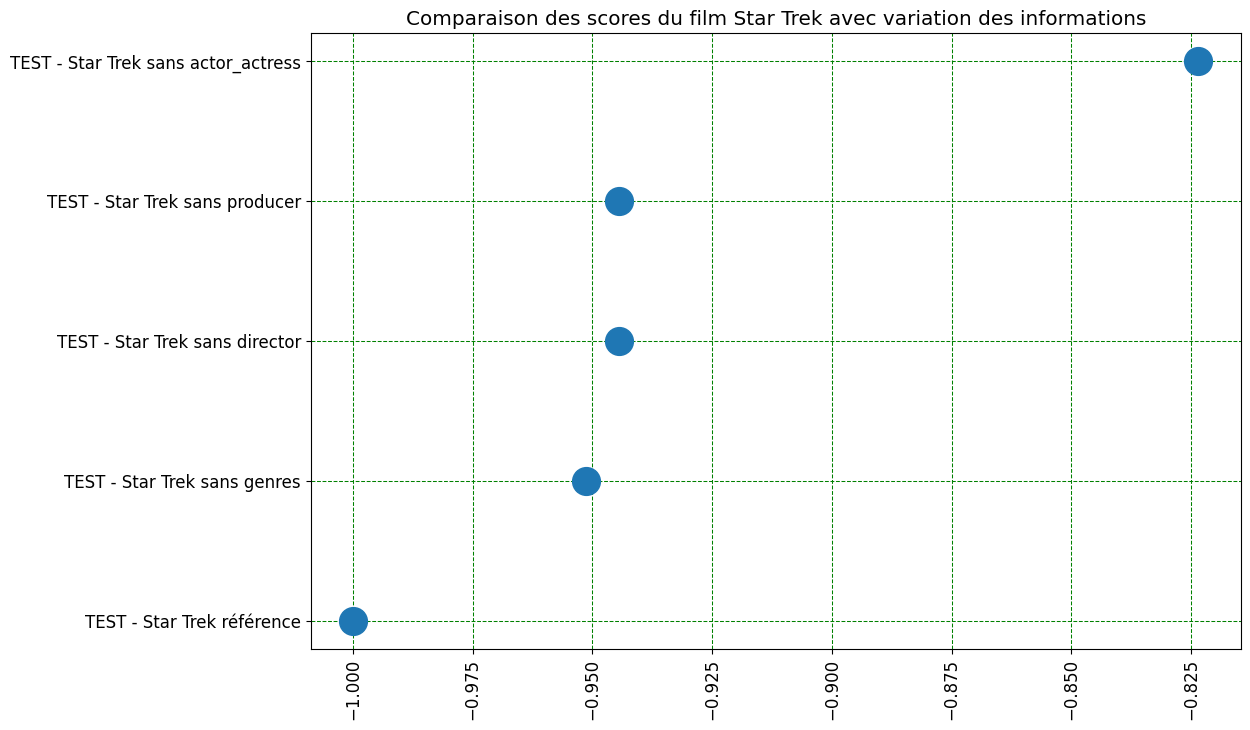

In [36]:
reco_ref = get_recommendations_t("Star Trek", matrice_tfidf, df_test)
df_reco_ref = pd.DataFrame(reco_ref)
df_reco_ref.columns =['movie_indices','recommanded_title','score']
df_reco_ref=df_reco_ref[df_reco_ref['recommanded_title'].str.contains("TEST - Star Trek")]
print(df_reco_ref)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.rcParams['font.size'] = '12'
y=df_reco_ref['score']
x=df_reco_ref['recommanded_title']
plt.title('Comparaison des scores du film Star Trek avec variation des informations')
plt.plot(-y,x, "o",markersize=20)
plt.tick_params(axis='x', rotation=90)
plt.grid(color='g', linestyle='--', linewidth=0.75)
plt.show

Chaque élément contribue à modifier le score de la recommandation.
Chaque élément intervien bien dans la détermination du score.
Pour le film Star Trek, l'élément le plus déterminant est les acteurs / actrices

Le modèle est basé sur le contenu : tous les éléments sont analysés et comptabilisés dans le calcul du score.
Le modèle est performant et offre de bonnes recommandation

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Autres Essais de modèles</a></div>

### 1er essai Modèle de recommandation (modèle qui fonctionne mais moins performant)

#### Implémentation

In [33]:
# Préparation des données
df['desc']=''
for i in df[df.columns[2:38]].columns.values:
    if df.select_dtypes !=('object'):
        df['desc']=df['desc']+" "+df[i].apply(str)
    else:
        df['desc']=df['desc']+" "+df[i]

In [34]:
# Créer un TfidfVectorizer et supprimer les mots vides
tfidf = TfidfVectorizer(stop_words='english')

#df['desc']=df['director']+df['actor_actress']+df['producer']

# Adapter et transformer les données en une matrice tfidf
matrice_tfidf = tfidf.fit_transform(df['desc'])

In [35]:
# Fonction pour calculer la similarité et obtenir les recommandations
def get_recommendations1(title, matrice_tfidf, df):
    if title not in df['title'].values:
        return "Ce film n'est pas dans la base de données."

    # Trouver l'index du film
    idx = df[df['title'] == title].index[0]
    
    # Calculer la similarité entre le film choisi et tous les autres
    cosine_sim = cosine_similarity(matrice_tfidf[idx:idx+1], matrice_tfidf).flatten()
    
    # Obtenir les indices des films les plus similaires
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Top 10, excluant le film lui-même
    
    # Récupérer les titres des films recommandés
    movie_indices = [i[0] for i in sim_scores]
    recommanded_title=df['title'].iloc[movie_indices]
    score=[i[1] for i in sim_scores]

    return list(zip(movie_indices,recommanded_title,score))

#### Exemples de recommandations

In [36]:
# Test de la fonction
get_recommendations1("Star Trek", matrice_tfidf, df)

[(97378, 'Star Trek Into Darkness', 0.817894906136071),
 (123732, 'Star Wars: Episode VII - The Force Awakens', 0.5614108056822318),
 (106415, 'Super 8', 0.5166679440439086),
 (125577, 'Star Trek Beyond', 0.5024675453375722),
 (124099, 'Star Wars: Episode IX - The Rise of Skywalker', 0.5003626188905832),
 (124293, 'The Cloverfield Paradox', 0.33615459625805666),
 (141037, 'Overlord', 0.32079900181593635),
 (83363, 'Cloverfield', 0.31566604864345943),
 (143146, 'Mission: Impossible - Fallout', 0.3156058644739994),
 (122189, 'Mission: Impossible - Rogue Nation', 0.3113456397955537)]

In [37]:
# Test de la fonction
get_recommendations1("Avengers: Endgame", matrice_tfidf, df)

[(138999, 'Avengers: Infinity War', 0.7109489304740392),
 (134598, 'Captain America: Civil War', 0.6966362538109778),
 (110980, 'Captain America: The Winter Soldier', 0.5357571297702469),
 (122521, 'Avengers: Age of Ultron', 0.5097780863823809),
 (78530, 'The Avengers', 0.4934373199157528),
 (92911, 'Iron Man 3', 0.34179146591341303),
 (90205, 'Iron Man 2', 0.32658512186158745),
 (152804, 'Everything Everywhere All at Once', 0.227547388573377),
 (134622, 'Thor: Ragnarok', 0.20122719699956665),
 (83519, 'Thor: Love and Thunder', 0.20037352871729683)]

In [38]:
# Test de la fonction
get_recommendations1("Rogue One: A Star Wars Story", matrice_tfidf, df)

[(136633, 'Solo: A Star Wars Story', 0.3017219418267342),
 (99682, 'Indiana Jones and the Dial of Destiny', 0.29904433417108384),
 (78155, 'Godzilla', 0.292603674420325),
 (130780, 'Inferno', 0.22130689376923263),
 (88707, 'The Creator', 0.21594186102937957),
 (99989, 'Monsters', 0.21217228429526927),
 (150178, 'The Aeronauts', 0.21130593064329473),
 (116636, 'Collide', 0.2077929885063174),
 (124228, 'Arrival', 0.19863663218872807),
 (154319, 'Dragon Rider', 0.19241927421378371)]

In [39]:
# Test de la fonction
get_recommendations1("Star Wars: Episode VII - The Force Awakens", matrice_tfidf, df)

[(77273, 'Star Trek', 0.5614108056822318),
 (97378, 'Star Trek Into Darkness', 0.5614108056822318),
 (106415, 'Super 8', 0.526263508290328),
 (124099, 'Star Wars: Episode IX - The Rise of Skywalker', 0.5096553604113601),
 (86228, 'Morning Glory', 0.4289629130401823),
 (125577, 'Star Trek Beyond', 0.3622647019810554),
 (124293, 'The Cloverfield Paradox', 0.3423976640974835),
 (141037, 'Overlord', 0.3267568853417051),
 (83363, 'Cloverfield', 0.3215286028914819),
 (143146, 'Mission: Impossible - Fallout', 0.3214673009807892)]

In [40]:
# Test de la fonction
get_recommendations1("Serenity", matrice_tfidf, df)

[(122521, 'Avengers: Age of Ultron', 0.28441678078988775),
 (78530, 'The Avengers', 0.2680132000811184),
 (79915, 'The Happening', 0.25743412163392454),
 (51715, 'Unbreakable', 0.2447496284551552),
 (35839, 'Digital Man', 0.21418703698108676),
 (40263, 'Rushmore', 0.18583593412292293),
 (91321, 'The Cabin in the Woods', 0.1822455196297543),
 (120911, 'War of the Worlds: Goliath', 0.18187291427769176),
 (88798, 'Peacock', 0.18184229938989208),
 (69544, 'Evil Eyes', 0.1754557571002041)]

In [41]:
# Test de la fonction
get_recommendations1("Jumanji", matrice_tfidf, df)

[(34112, 'Mrs. Doubtfire', 0.28094947699875067),
 (31852, "Bill & Ted's Bogus Journey", 0.23747439166048367),
 (32403, 'The Rocketeer', 0.23074740646449213),
 (84438, 'Bill & Ted Face the Music', 0.2290766811319618),
 (32930, "The Gun in Betty Lou's Handbag", 0.2259203573670512),
 (30423, 'Honey, I Shrunk the Kids', 0.2126837442557355),
 (24634, 'Popeye', 0.2069664488662104),
 (40732, 'October Sky', 0.20689955050298062),
 (73029, 'RV', 0.20480044074712012),
 (69391, 'Breach', 0.2039013718434594)]

In [42]:
get_recommendations1("Toy Story", matrice_tfidf, df)

[(38502, 'Toy Story 2', 0.3801714280632297),
 (113410, 'Toy Story 4', 0.35486710253927944),
 (104575, 'Larry Crowne', 0.31105505868448785),
 (63315, 'Over the Hedge', 0.26138879297068396),
 (44387, 'Cast Away', 0.2608943713986091),
 (38749, 'Tarzan', 0.25617820678263037),
 (89793, 'Cars 2', 0.25227751327267134),
 (106318, 'How to Train Your Dragon 2', 0.2507406087501409),
 (122314, 'How to Train Your Dragon: The Hidden World', 0.2507406087501409),
 (154903, 'Luck', 0.25015520383467066)]

#### Interpretabilité

Je calcule les scores du films recommandé pour le film "Star Trek" en comparant les scores avec et sans les genres

In [43]:
#Recommandations d eréférence : films premant l'ensemble des variables
reco_ref=get_recommendations1("Star Trek", matrice_tfidf, df)

df_reco_ref = pd.DataFrame(reco_ref)
#df      = pd.DataFrame(np.array([lst]).T)
df_reco_ref.columns =['movie_indices','recommanded_title','score']
df_reco_ref

,movie_indices,recommanded_title,score
0,97378,Star Trek Into Darkness,0.817895
1,123732,Star Wars: Episode VII - The Force Awakens,0.561411
2,106415,Super 8,0.516668
3,125577,Star Trek Beyond,0.502468
4,124099,Star Wars: Episode IX - The Rise of Skywalker,0.500363
5,124293,The Cloverfield Paradox,0.336155
6,141037,Overlord,0.320799
7,83363,Cloverfield,0.315666
8,143146,Mission: Impossible - Fallout,0.315606
9,122189,Mission: Impossible - Rogue Nation,0.311346


In [44]:
#On calcule pas la matrice pour l'ensemble du catalogue mais pour chaque titre recherché

# Fonction pour calculer la similarité et obtenir les recommandations
def simu_compare(title,matrice_tfidf, df):

    # Index du film
    idx = df[df['title'] == title].index[0]
        
    # Calculer la similarité entre le film choisi et tous les autres
    cosine_sim = cosine_similarity(matrice_tfidf[idx:idx+1], matrice_tfidf).flatten()
    
    # Obtenir les indices des films les plus similaires
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #sim_scores = sim_scores[1:16]  # Top 10, excluant le film lui-même
    
    # Récupérer les titres des films recommandés
    movie_indices = [i[0] for i in sim_scores]
    recommanded_title=df['title'].iloc[movie_indices]
    score=[i[1] for i in sim_scores]

    reco=list(zip(movie_indices,recommanded_title,score))
    df_reco = pd.DataFrame(reco)
    df_reco.columns =['movie_indices','recommanded_title','score']

    df_reco=df_reco_ref.merge(right= df_reco, on = 'recommanded_title', how = 'left')

    return df_reco
    #return list(zip(movie_indices,recommanded_title,score))

In [45]:
#Je compare les résultats en conservant uniquement les variables director / actor_actress / producer
df['desc_test1']=df['director']+" "+df['actor_actress']+" "+df['producer']

# Adapter et transformer les données en une matrice tfidf
matrice_tfidf = tfidf.fit_transform(df['desc_test1'])

# Test de la fonction
df_reco=simu_compare("Star Trek",matrice_tfidf, df)
df_reco

,movie_indices_x,recommanded_title,score_x,movie_indices_y,score_y
0,97378,Star Trek Into Darkness,0.817895,97378,1.000000
1,123732,Star Wars: Episode VII - The Force Awakens,0.561411,123732,0.657455
2,106415,Super 8,0.516668,106415,0.612545
3,125577,Star Trek Beyond,0.502468,125577,0.592822
4,124099,Star Wars: Episode IX - The Rise of Skywalker,0.500363,124099,0.625374
5,124293,The Cloverfield Paradox,0.336155,124293,0.380634
6,141037,Overlord,0.320799,141037,0.355677
7,83363,Cloverfield,0.315666,83363,0.367521
8,143146,Mission: Impossible - Fallout,0.315606,143146,0.397311
9,122189,Mission: Impossible - Rogue Nation,0.311346,122189,0.389570


### Modèle (KO)

In [24]:
#1ère tentative en utilisant de modèle collaboratif utilisant la metrique de cosimilarité et la metrique euclidienne
#Ce modèle necessitait trop de mémoire de calcul

In [25]:
#Préparation des données
#df['desc']=''
#for i in df[df.columns[4:38]].columns.values:
#    if df.select_dtypes !=('object'):
#        df['desc']=df['desc']+" "+df[i].apply(str)
#    else:
#        df['desc']=df['desc']+" "+df[i]

In [26]:
# Créer un TfidfVectorizer et supprimer les mots vides
#tfidf = TfidfVectorizer(stop_words='english')

#df['desc']=df['director']+df['actor_actress']+df['producer']

# Adapter et transformer les données en une matrice tfidf
#matrice_tfidf = tfidf.fit_transform(df['title'])

In [27]:
#indices = pd.Series(range(0,len(df)), index=df['title'])

In [28]:
#sim_cosinus = cosine_similarity(matrice_tfidf, matrice_tfidf)

In [29]:
# On calcule la similarité euclidienne
#sim_euclidienne = 1 / (1 + euclidean_distances(matrice_tfidf[:1000]))

#print(sim_euclidienne.shape)
#print(type(sim_euclidienne))

In [30]:
#from tabulate import tabulate
#def recommandations(titre, mat_sim, num_recommendations = 10):
    # On récupère l'indice associé au titre qui servira à identifier le livre dans la matrice de similarité
    #idx = indices[titre]

    # On obtient les scores de similarité de tous les films et on les garde les tuples d'indice du film 
    # et score dans une liste
    #scores_similarite = list(enumerate(mat_sim[idx]))

    # On trie les livres en fonction des scores de similarité
    #scores_similarite = sorted(scores_similarite, key=lambda x: x[1], reverse=True)

    # Obtenir les scores des 10 livres les plus similaires
    #top_similair = scores_similarite[1:num_recommendations+1]

    # Obtenir les indices des livres
    #res = [(indices.index[idx], score) for idx, score in top_similair]

    # Renvoyer les titres des livres les plus similaires
    #return tabulate(res, headers=["Titre", "Score de similarité"], tablefmt="pretty")

In [31]:
#print("Recommandations pour 'Miss Jerry' similarité cosinus: \n",
#      recommandations('Miss Jerry', sim_cosinus))

#print("\n Recommandations pour 'Miss Jerry' similarité euclidienne: \n",
#      recommandations('Miss Jerry', sim_euclidienne))

#print("\n Recommandations pour 'The Story of the Kelly Gang' similarité cosinus: \n",
#      recommandations('The Story of the Kelly Gang', sim_cosinus))

#print("\n Recommandations pour The Story of the Kelly Gang' similarité euclidienne: \n",
#      recommandations('The Story of the Kelly Gang', sim_euclidienne))

### Variante avec la metrique euclidienne (recommandations similaires)

In [ ]:
#ce calcul apporte des recommandations identiques à la recommandation avec la metric cosine

In [ ]:
#Préparation des données
#df['desc']=''
#for i in df[df.columns[4:38]].columns.values:
#    if df.select_dtypes !=('object'):
#        df['desc']=df['desc']+" "+df[i].apply(str)
#    else:
#        df['desc']=df['desc']+" "+df[i]

In [ ]:
# Créer un TfidfVectorizer et supprimer les mots vides
#tfidf = TfidfVectorizer(stop_words='english')

#df['desc']=df['director']+df['actor_actress']+df['producer']

# Adapter et transformer les données en une matrice tfidf
#matrice_tfidf = tfidf.fit_transform(df['title'])

In [ ]:
#indices = pd.Series(range(0,len(df)), index=df['title'])

In [ ]:
#sim_cosinus = cosine_similarity(matrice_tfidf, matrice_tfidf)

In [ ]:
# Fonction pour calculer la similarité et obtenir les recommandations
#def get_recommendations2(title, matrice_tfidf, df):
    #if title not in df['title'].values:
        #return "Ce film n'est pas dans la base de données."

    # Trouver l'index du film
    #idx = df[df['title'] == title].index[0]
    
    # Calculer la similarité entre le film choisi et tous les autres
    #cosine_sim = cosine_similarity(matrice_tfidf[idx:idx+1], matrice_tfidf).flatten()
    #sim_euclidienne = 1/(1+euclidean_distances(matrice_tfidf[idx:idx+1], matrice_tfidf)).flatten()
    
    # Obtenir les indices des films les plus similaires
    #sim_scores = list(enumerate(sim_euclidienne))
    #sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #sim_scores = sim_scores[1:11]  # Top 10, excluant le film lui-même
    
    # Récupérer les titres des films recommandés
    #movie_indices = [i[0] for i in sim_scores]
    #recommanded_title=df['title'].iloc[movie_indices]
    #score=[i[1] for i in sim_scores]
    #return df['title'].iloc[movie_indices]
    #return list(zip(movie_indices, recommanded_title,score))

In [ ]:
# Test de la fonction
#get_recommendations2("Star Trek", matrice_tfidf, df)

### Autre essai de modèle -> resultats non concluants

In [ ]:
#!pip install surprise

In [ ]:
#from surprise import Reader
#from surprise import Dataset

In [ ]:
#df['desc']=''
#for i in df[df.columns[7:38]].columns.values:
    #print(i)
    #if df.select_dtypes !=('object'):
        #df['desc']=df['desc']+df[i].apply(str)
    #else:
        #df['desc']=df['desc']+df[i]

#print(df['desc'])
#print(df['title'])

In [ ]:
#reader = Reader(rating_scale=(0, 5))

#df['ScorePondere']=df['numVotes']*df['averageRating']

#df_surprise = Dataset.load_from_df(df[["desc", "title", "ScorePondere"]], reader=reader)

In [ ]:
#from surprise import NormalPredictor
#from surprise.model_selection import cross_validate

#normpred = NormalPredictor()

#cross_validate(normpred, df_surprise, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
#type_movie="0000000010000000000000000000000"

In [ ]:
# Construire le jeu d'entraînement complet à partir du DataFrame df_surprise
#train_set = df_surprise.build_full_trainset()

# Initialiser une liste vide pour stocker les paires (utilisateur, tittle) pour le jeu "anti-testset"
#anti_testset = []

# Convertir l'ID de l'utilisateur externe en l'ID interne utilisé par Surprise
#targetUser = train_set.to_inner_uid(type_movie)

# Obtenir la valeur de remplissage à utiliser (moyenne globale des notes du jeu d'entraînement)
#moyenne = train_set.global_mean

# Obtenir les évaluations de l'utilisateur cible pour les films
#user_note = train_set.ur[targetUser]

# Extraire la liste des livres notés par l'utilisateur
#user_movie = [item for (item,_) in (user_note)]

# Obtenir toutes les notations du jeu d'entraînement
#ratings = train_set.all_ratings()

# Boucle sur tous les items du jeu d'entraînement
#for movie in train_set.all_items():
    # Si l'item n'a pas été noté par l'utilisateur
    #if movie not in user_movie:
        # Ajouter la paire (utilisateur, movie, valeur de remplissage) à la liste "anti-testset"
        #anti_testset.append((type_movie, train_set.to_raw_iid(movie), moyenne))

In [ ]:
# Effectuer les prédictions sur l'ensemble "anti-testset_user" en utilisant le modèle (non spécifié dans le code)
#predictions = normpred.test(anti_testset)  

# Convertir les prédictions en un DataFrame pandas
#predictions = pd.DataFrame(predictions)

# Trier les prédictions par la colonne 'est' (estimation) en ordre décroissant
#predictions.sort_values(by=['est'], inplace=True, ascending=False)

# Afficher les 10 meilleures prédictions
#predictions.head(10)